**Processamento Digital de Imagens - 2022/01**<br/>
**Engenharia da Computação**<br/>
**Aluno:** Gabriel Soares Baptista, 2018102117<br/>

### Questão 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple

### Funções auxiliares

In [2]:
def image_plot(image: np.array, size: Tuple[int, int], scaled: bool = False) -> None:
    """ Plota a imagem com as informações passadas """
    plt.figure(figsize=size)
    if not scaled:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()


def image_normalize(image: np.array) -> np.array:
    """ Normaliza os valores da imagens para o intervalo [0, 255] """
    v_min = float(image.min())
    v_max = float(image.max())
    normalized_image = np.round((image - v_min)/(v_max - v_min) * 255)
    return np.array(normalized_image, dtype=np.uint8)


def get_histogram(image: np.array) -> np.array:
    """
    Retorna um vetor do numpy contando tamanho 256, onde cada
    valor corresponde a quantidade de pixels com a intensidade
    da posição.
    """
    histogram = np.zeros(shape=256, dtype=np.uint32)

    # fill vector
    for row in image:
        for pixel in row:
            histogram[int(pixel)] += 1
    
    return histogram

### Resolução

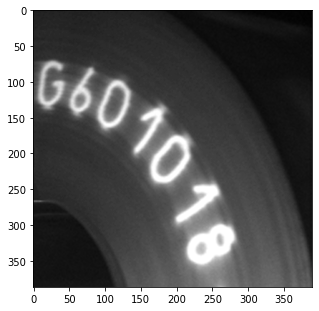

In [3]:
# convert to gray scale
image = Image.open('../images/image.png').convert('L')
# read image as double
image = np.array(image, dtype=np.double)
image_plot(image, (5, 6))

Uma solução para esse problema utiliza-se do modelo multiplicativo entre refletância e iluminância, para isso, considera-se que a imagem definida pela função $f(x,y)$ pode ser caracterizada por dois componentes, a iluminação da fonte que incide na cena e a quantidade de iluminação refletida pelos objetos na cena.

Portanto, podemos definir a função da imagem na forma:
$$
f(x, y) = i(x,y)r(x,y) \\
$$

onde

$$
0 \lt i(x,y) \lt \infty \\
\text{e} \\
0 \lt r(x,y) \lt 1
$$

Podemos utilizar o modelo iluminação-refletância definido para desenvolver um procedimento no domínio da frequência que melhor a aparência da imagem através da compressão da faixa de intensidade e o realce do contraste. Entretanto, o modelo não pode ser utilizado diretamente sobre os componentes de frequência, uma vez que a transformada de Fourier de um produto não é o produto das transformadas. Portanto, a operação é aplicada sobre o logarítmo da imagem.

$$
z(x, y) = ln f(x, y) \\
\qquad\qquad\qquad\qquad = \text{ln } i(x, y) + \text{ln } r(x, y) 
$$

Portanto, podemos filtrar $Z(x, y)$ utilizando um filtro $H(u,v)$ de forma que $S(u,v) = H(u,v)Z(u,v) = H(u,v)F_i(u,v) + H(u,v)F_r(u,v)$.

In [4]:
# get Fourier transform
image_log = np.log(image + 0.01)
image_fill = np.zeros((2*image.shape[0], 2*image.shape[1]))
image_fill[0:image.shape[0],0:image.shape[1]] = image_log
F_shift = np.fft.fftshift(np.fft.fft2(image_fill))

# get D variable
y = np.arange(-image.shape[0], image.shape[0], 1)
x = np.arange(-image.shape[1], image.shape[1], 1) 
u, v = np.meshgrid(x, y)
D = np.sqrt(u**2 + v**2)

# get homomorphic filter
c = 1
d0 = 700
yh = 0.6
yl = 0.2
H = (yh - yl)*(1 - np.exp(-c*((D**2)/(d0**2)))) + yl

# apply filter
G_homomorphic = F_shift*H
homomorphic_image_fill = np.abs(np.fft.ifft2(np.fft.fftshift(G_homomorphic)))
homomorphic_image = homomorphic_image_fill[0:image.shape[0],0:image.shape[1]]
homomorphic_image = np.exp(homomorphic_image)

Essa metodologia é denominada de `sistemas homomórficos`, onde separa-se as componentes de iluminação e refletância, nos permitindo atuar separadamente sobre elas.

Logo, queremos um filtro $H(u,v)$ que afete os componentes de alta e baixx frequência da transformada de Fourier de formas diferentes e controláveis. Considerando ums parâmetros $\gamma_l$ e $\gamma_h$ de forma que $\gamma_l \lt 1$ e $\gamma_h \gt 1$, a funçao tende a ateunar a contribuição das baixas frequências, nesse contexto a iluminação e ampliar a contribuição das altas frequências, refletância.

Nesse caso, temos que aplicar o logarítimo na imagem, obter a transformada de Fourier, aplicar o filtro homomórfico, obter a inversa e aplicar uma transformação exponencial.

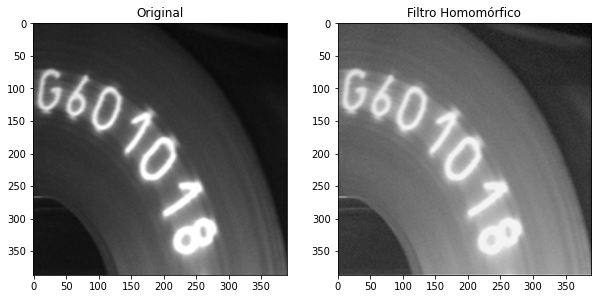

In [5]:
# plot filtered image
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10)) 
axs[0].imshow(image,cmap='gray')
axs[1].imshow(homomorphic_image,cmap='gray') 
axs[0].set_title('Original')
axs[1].set_title('Filtro Homomórfico')
plt.show()

Podemos observar o histograma da imagem para analisar a diferença das distribuições de intensidade e chegar se a melhora não foi apenas visual.

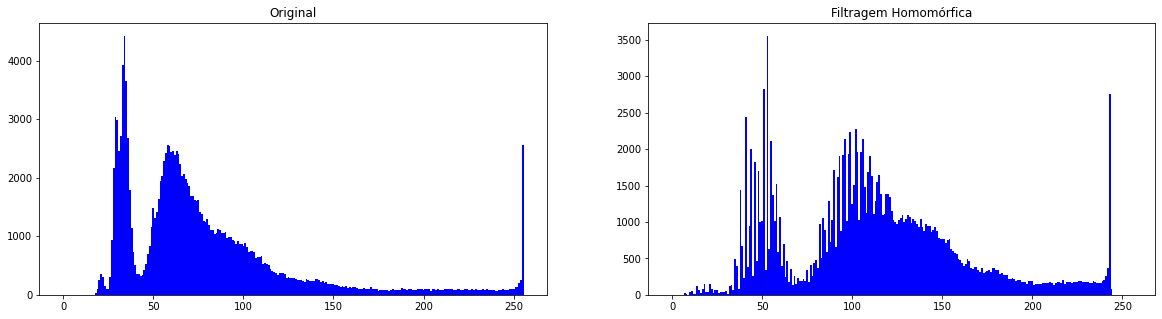

In [6]:
image_histogram = get_histogram(image)
homomorphic_image_histogram = get_histogram(image_normalize(homomorphic_image))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) 
axs[0].bar(list(range(image_histogram.shape[0])), image_histogram, color ='blue', width=1)
axs[1].bar(list(range(image_histogram.shape[0])), homomorphic_image_histogram, color ='blue', width=1)
axs[0].set_title('Original')
axs[1].set_title('Filtragem Homomórfica')
plt.show()

Observa-se pelos histogramas acima que a filtragem homomórfica obteve uma melhora considerável. A esquerda temos uma distribuição que se assemelha muito a uma cauda longa, enquanto que na direita obtemos algo muito mais próximo de uma distribuição normal, ainda que exista uma quantidade significativa de valores nas extremidades.

### Imagem 2

Nessa etapa repete-se o procedimento para segunda imagem, onde podemos observar uma melhora muito parecido com o que ocorreu para a anterior.

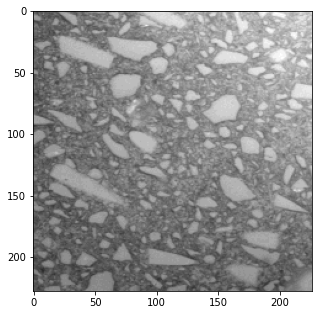

In [7]:
# convert to gray scale
image2 = Image.open('../images/mar-il.gif').convert('L')

# read image as double
image2 = np.array(image2, dtype=np.double)
image_plot(image2, (5, 6))

In [8]:
# get Fourier transform
image2_log = np.log(image2 + 0.01)
image2_fill = np.zeros((2*image2.shape[0], 2*image2.shape[1]))
image2_fill[0:image2.shape[0],0:image2.shape[1]] = image2_log
F_shift2 = np.fft.fftshift(np.fft.fft2(image2_fill))

# get D variable
y = np.arange(-image2.shape[0], image2.shape[0], 1)
x = np.arange(-image2.shape[1], image2.shape[1], 1) 
u, v = np.meshgrid(x, y)
D2 = np.sqrt(u**2 + v**2)

# get homomorphic filter
c = 1
d0 = 275
yh = 0.6
yl = 0.4
H2 = (yh - yl)*(1 - np.exp(-c*((D2**2)/(d0**2)))) + yl

# apply filter
G_homomorphic2 = F_shift2*H2
homomorphic_image2_fill = np.abs(np.fft.ifft2(np.fft.fftshift(G_homomorphic2)))
homomorphic_image2 = homomorphic_image2_fill[0:image2.shape[0],0:image2.shape[1]]
homomorphic_image2 = np.exp(homomorphic_image2)

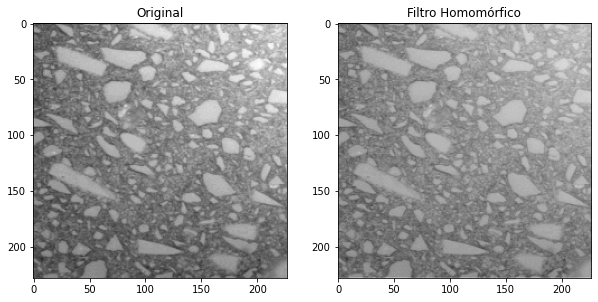

In [9]:
# plot filtered image
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10)) 
axs[0].imshow(image2,cmap='gray')
axs[1].imshow(homomorphic_image2,cmap='gray') 
axs[0].set_title('Original')
axs[1].set_title('Filtro Homomórfico')
plt.show()

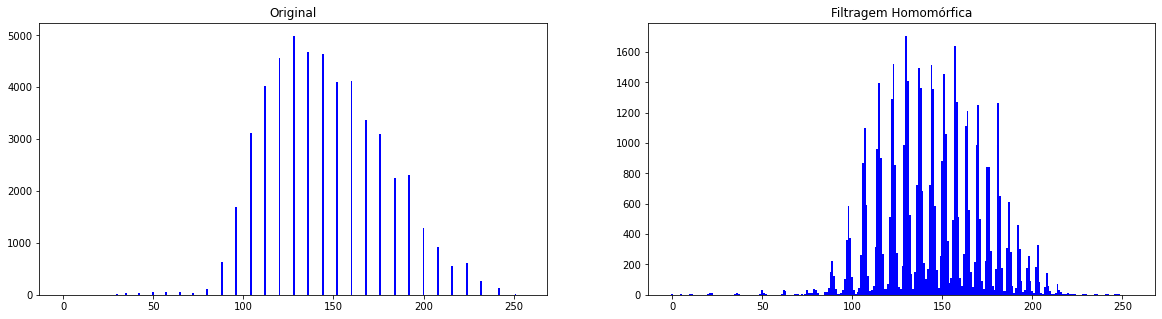

In [10]:
image2_histogram = get_histogram(image2)
homomorphic_image2_histogram = get_histogram(image_normalize(homomorphic_image2))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) 
axs[0].bar(list(range(image_histogram.shape[0])), image2_histogram, color ='blue', width=1)
axs[1].bar(list(range(image_histogram.shape[0])), homomorphic_image2_histogram, color ='blue', width=1)
axs[0].set_title('Original')
axs[1].set_title('Filtragem Homomórfica')
plt.show()

Observa-se que, assim como para imagem anterior, o histograma teve uma melhora considerável embora visualmente o resultado não tenha uma melhora tão grande, o histograma melhora consideravalmente, nos permitindo utilizar uma série de outras técnicas de forma mais eficiente. Entretanto, é importante destacar que os resultas obtidos poderiam ser melhores com um ajuste mais fino dos parâmetros do filtro.

### Apêndice

Código utilizado para testar os valores, necessário ipywidgets, rode todas células anteriores para rodar as duas abaixo.

In [ ]:
from ipywidgets import interactive, HBox,VBox

def f(gamma_h, gamma_l, c, D0):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5)) 
    axs.imshow(image,cmap='gray')

    # get homomorphic filter
    C = c
    d0 = D0
    yh = gamma_h
    yl = gamma_l
    H = (yh - yl)*(1 - np.exp(-C*((D**2)/(d0**2)))) + yl

    # apply filter
    G_homomorphic = F_shift*H
    homomorphic_image_fill = np.abs(np.fft.ifft2(np.fft.fftshift(G_homomorphic)))
    homomorphic_image = homomorphic_image_fill[0:image.shape[0],0:image.shape[1]]
    homomorphic_image = np.exp(homomorphic_image)
    axs.imshow(homomorphic_image,cmap='gray') 
    axs.set_title('Filtro Homomórfico')
    plt.show()

widget = interactive(f, gamma_h=(0, 2.0, 0.1), gamma_l=(0, 2, 0.1), c=(0, 100, 1.0), D0=(0, 1000, 5.0))
controls = VBox(widget.children[:-1])
output = widget.children[-1]
display(HBox([controls, output]))

In [ ]:
from ipywidgets import interactive, HBox,VBox

def f(gamma_h, gamma_l, c, D0):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5)) 
    axs.imshow(image,cmap='gray')

    # get homomorphic filter
    C = c
    d0 = D0
    yh = gamma_h
    yl = gamma_l
    H2 = (yh - yl)*(1 - np.exp(-C*((D2**2)/(d0**2)))) + yl

    # apply filter
    G_homomorphic2 = F_shift2*H2
    homomorphic_image2_fill = np.abs(np.fft.ifft2(np.fft.fftshift(G_homomorphic2)))
    homomorphic_image2 = homomorphic_image2_fill[0:image2.shape[0],0:image2.shape[1]]
    homomorphic_image2 = np.exp(homomorphic_image2)
    axs.imshow(homomorphic_image2,cmap='gray') 
    axs.set_title('Filtro Homomórfico')
    plt.show()

widget = interactive(f, gamma_h=(0, 2.0, 0.1), gamma_l=(0, 2, 0.1), c=(0, 100, 1.0), D0=(0, 1000, 5.0))
controls = VBox(widget.children[:-1])
output = widget.children[-1]
display(HBox([controls, output]))